In [25]:
import numpy as np
import matplotlib.pyplot as plt
import math
import time
import pandas as pd
import datetime as dt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, LSTM, Conv1D, Input, Bidirectional, GRU, Average
from sklearn.metrics import mean_squared_error

from PyEMD import EMD
import CEEMDAN_LSTM as cl

In [26]:
df_path = "data/one_year_complete.csv"
org_df = pd.read_csv(df_path,sep=',')
org_df['date'] = pd.to_datetime(org_df['date'])
org_df = org_df.set_index('date')
org_df.head(10)

,open,high,low,close,Volume BTC,tradecount,pos,neg,neu
date,,,,,,,,,
2021-01-01,28923.63,29600.00,28624.57,29331.69,54182.92501,1314910,0.45845,0.05001,0.49154
2021-01-02,29331.70,33300.00,28946.53,32178.33,129993.87340,2245922,0.57480,0.05203,0.37317
2021-01-03,32176.45,34778.11,31962.99,33000.05,120957.56680,2369698,0.48389,0.05885,0.45726
2021-01-04,33000.05,33600.00,28130.00,31988.71,140899.88570,2642408,0.38149,0.08008,0.53843
2021-01-05,31989.75,34360.00,29900.00,33949.53,116049.99700,2526851,0.52304,0.08422,0.39274
2021-01-06,33949.53,36939.21,33288.00,36769.36,127139.20130,2591783,0.45125,0.10656,0.44219
2021-01-07,36769.36,40365.00,36300.00,39432.28,132825.70040,2814686,0.47229,0.08922,0.43849
2021-01-08,39432.48,41950.00,36500.00,40582.81,139789.95750,2925632,0.58689,0.10403,0.30908
2021-01-09,40586.96,41380.00,38720.00,40088.22,75785.97968,1998156,0.33868,0.11207,0.54925


In [27]:
ns_df = org_df[['open','high', 'low', 'close', 'Volume BTC']]  #nonsentimental df
ns_df.head(5)

,open,high,low,close,Volume BTC
date,,,,,
2021-01-01,28923.63,29600.00,28624.57,29331.69,54182.92501
2021-01-02,29331.70,33300.00,28946.53,32178.33,129993.87340
2021-01-03,32176.45,34778.11,31962.99,33000.05,120957.56680
2021-01-04,33000.05,33600.00,28130.00,31988.71,140899.88570
2021-01-05,31989.75,34360.00,29900.00,33949.53,116049.99700


In [28]:
# function to split the data
def create_dataset(dataset, pred_col, look_back=1):
  dataX, dataY = [], []
  for i in range(len(dataset)-look_back-1):
    a = dataset[i:(i+look_back), :]
    dataX.append(a)
    dataY.append(dataset[i + look_back, pred_col])
  return np.array(dataX), np.array(dataY)

In [29]:
def get_model(params, input_shape, num_features):
    if (params["model_type"] == "lstm"):
        #print(params["expr_name"] +"/"+ params["model_type"])
        model = Sequential()
        model.add(LSTM(params["lstm_units"], input_shape=(input_shape,num_features)))
        model.add(Dense(1))
        model.compile(loss=params["loss"], optimizer=params["optimizer"])
        return model
    elif (params["model_type"] == "stacked_lstm"):
        #print(params["expr_name"] +"/"+ params["model_type"])
        model = Sequential()
        model.add(LSTM(units=params["lstm_units"], return_sequences=True, input_shape=(input_shape, num_features)))
        model.add(Dropout(rate=params["dropout"]))
        model.add(LSTM(units=int(params["lstm_units"] / 2), return_sequences=False))
        model.add(Dropout(rate=params["dropout"]))
        model.add(Dense(1))
        model.compile(loss=params["loss"],optimizer=params["optimizer"])
        return model
    elif (params["model_type"] == "bidirectional_lstm"):
        #print(params["expr_name"] +"/"+ params["model_type"])
        model = Sequential()
        model.add(Bidirectional(LSTM(units=params["lstm_units"], return_sequences=True, dropout=params["dropout"], input_shape=(input_shape, num_features))))
        model.add(Bidirectional(LSTM(units=int(params["lstm_units"] / 2) , dropout=params["dropout"], return_sequences=False)))
        model.add(Dense(1))
        model.compile(loss=params["loss"],optimizer=params["optimizer"])
        return model
    elif (params["model_type"] == "gru"):
        #print(params["expr_name"] +"/"+ params["model_type"])
        model = Sequential()
        model.add(GRU(units=params["lstm_units"], input_shape=(input_shape, num_features), activation='tanh'))
        model.add(Dropout(rate=params["dropout"]))
        model.add(Dense(1))
        model.compile(loss=params["loss"],optimizer=params["optimizer"])
        return model
    elif (params["model_type"] == "stacked_gru"):
        #print(params["expr_name"] +"/"+ params["model_type"])
        model = Sequential()
        model.add(GRU(units=params["lstm_units"], return_sequences=True, input_shape=(input_shape, num_features), activation='tanh'))
        model.add(Dropout(rate=params["dropout"]))
        model.add(GRU(units=int(params["lstm_units"] / 2), return_sequences=False, activation='tanh'))
        model.add(Dropout(rate=params["dropout"]))
        model.add(Dense(1))
        model.compile(loss=params["loss"],optimizer=params["optimizer"])
        return model
    elif (params["model_type"] == "bidirectional_gru"):
        #print(params["expr_name"] +"/"+ params["model_type"])
        model = Sequential()
        model.add(Bidirectional(GRU(units=params["lstm_units"], return_sequences=True, dropout=params["dropout"], input_shape=(input_shape, num_features), activation='tanh')))
        model.add(Bidirectional(GRU(units=int(params["lstm_units"] / 2) , dropout=params["dropout"], return_sequences=False, activation='tanh')))
        model.add(Dense(1))
        model.compile(loss=params["loss"],optimizer=params["optimizer"])
        return model
    elif (params["model_type"] == "1dcnn_lstm"):
        #print(params["expr_name"] +"/"+ params["model_type"])
        input_layer = Input(shape=(input_shape, num_features))
        conv1 = Conv1D(filters=params["lstm_units"],
               kernel_size=3,
               strides=1,
               activation='relu',
               padding='same')(input_layer)
        lstm1 = LSTM(units=params["lstm_units"])(conv1)
        output_layer = Dense(1, activation='sigmoid')(lstm1)
        model = Model(inputs=input_layer, outputs=output_layer)
        model.compile(loss=params["loss"],optimizer=params["optimizer"])
        return model
    elif (params["model_type"] == "1dcnn_gru"):
        #print(params["expr_name"] +"/"+ params["model_type"])
        input_layer = Input(shape=(input_shape, num_features))
        conv1 = Conv1D(filters=params["lstm_units"],
               kernel_size=3,
               strides=1,
               activation='relu',
               padding='same')(input_layer)
        gru1 = GRU(units=params["lstm_units"], activation='tanh')(conv1)
        output_layer = Dense(1, activation='tanh')(gru1)
        model = Model(inputs=input_layer, outputs=output_layer)
        model.compile(loss=params["loss"],optimizer=params["optimizer"])
        return model
    

In [62]:
def evaluateModel(df, params):
    expr_name = params['expr_name']
    look_back = params['look_back']
    lstm_units = params['lstm_units']
    epochs=params['epochs']
    batch_size=params['batch_size']
    train_size_percent = params['train_size_percent']
    plot = params['plot']
    #scale data
    dataset = df.values
    dataset = dataset.astype('float32')
    scaler = MinMaxScaler(feature_range=(0, 1))
    dataset = scaler.fit_transform(dataset)
    num_of_features = len(df.columns)
    #split data
    pred_col = df.columns.get_loc('close')
    train_size = int(len(dataset) * train_size_percent)
    test_size = len(dataset) - train_size
    print(train_size, test_size)
    train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]

    trainX, trainY = create_dataset(train, pred_col, look_back=look_back)
    testX, testY = create_dataset(test, pred_col, look_back=look_back)
    # reshape input to be  [samples, time steps, features]
    trainX = np.reshape(trainX, (trainX.shape[0], look_back, num_of_features))
    testX = np.reshape(testX, (testX.shape[0],look_back, num_of_features))    
    print(len(trainX), len(testX))
    print(len(trainY), len(testY))
    # create and fit the LSTM network
    #model = Sequential()
    #model.add(LSTM(lstm_layers, input_shape=(look_back,num_of_features)))
    #model.add(Dense(1))
    #model.compile(loss='mean_squared_error', optimizer='adam')
    model = get_model(params, look_back, num_of_features)
    history= model.fit(trainX, trainY,validation_split=0.30, epochs=epochs, batch_size=batch_size,shuffle=False, verbose=0)
    if (plot):
        # Plot training
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('Model loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['training', 'validation'], loc='upper right')
        plt.show()
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)
    print(len(trainPredict), len(testPredict))
    # Get something which has as many features as dataset
    trainPredict_extended = np.zeros((len(trainPredict),num_of_features))
    # Put the predictions there
    trainPredict_extended[:,pred_col] = trainPredict[:,0]
    # Inverse transform it and select the 3rd column.
    trainPredict = scaler.inverse_transform(trainPredict_extended) [:,pred_col]

    # Get something which has as many features as dataset
    testPredict_extended = np.zeros((len(testPredict),num_of_features))
    # Put the predictions there
    testPredict_extended[:,pred_col] = testPredict[:,0]
    # Inverse transform it and select the pred_col column.
    testPredict = scaler.inverse_transform(testPredict_extended)[:,pred_col] 

    trainY_extended = np.zeros((len(trainY),num_of_features))
    trainY_extended[:,pred_col]=trainY
    trainY = scaler.inverse_transform(trainY_extended)[:,pred_col]

    testY_extended = np.zeros((len(testY),num_of_features))
    testY_extended[:,pred_col]=testY
    testY = scaler.inverse_transform(testY_extended)[:,pred_col]

    # calculate root mean squared error
    trainScore_RMSE = math.sqrt(mean_squared_error(trainY, trainPredict))
    testScore_RMSE = math.sqrt(mean_squared_error(testY, testPredict))

    # calculate absolute mean error
    trainScore_MAE = np.sum(np.absolute(trainY - trainPredict))/len(trainY)
    testScore_MAE = np.sum(np.absolute(testY - testPredict))/len(testY)
    
    if (plot):
        # shift train predictions for plotting
        trainPredictPlot = np.empty_like(dataset)
        trainPredictPlot[:, :] = np.nan
        trainPredictPlot[look_back:len(trainPredict)+look_back, pred_col] = trainPredict

        # shift test predictions for plotting
        testPredictPlot = np.empty_like(dataset)
        testPredictPlot[:, :] = np.nan
        testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, pred_col] = testPredict

        # contruct pandas dataframe for plotting
        time_df = pd.DataFrame(df.index)
        time_df['Actual'] = scaler.inverse_transform(dataset)[:,pred_col]
        df1 = pd.DataFrame(trainPredictPlot[:,pred_col],columns=['Train'])
        df2 = pd.DataFrame(testPredictPlot[:,pred_col],columns=['Test'])
        time_df2 = pd.concat([time_df, df1, df2], axis=1, sort=False)
        time_df2.set_index('date',inplace=True)

        # plot the output
        fig, ax = plt.subplots(figsize=(15,7))
        time_df2.plot(ax=ax,rot=90,alpha=0.7)
        plt.xlabel('date')
        plt.ylabel('Bitcoin Value')
        plt.title('Bitcoin Price Prediction')
        plt.savefig(expr_name + '.png',bbox_inches = "tight")
        print('-' * 50)
        print('Experiment name:', expr_name)

        print('-' * 50)
        print('look_back days:', look_back/24)
        print('lstm_units:', lstm_units)
        print('epochs:', epochs)
        print('batch_size:', batch_size)
        print('dataset features', list(df.columns))


        print('-' * 50)
        print('Train Score: %.2f RMSE' % (trainScore_RMSE))
        print('Test Score: %.2f RMSE' % (testScore_RMSE))

        print('-' * 50)
        print('Train Score: %.2f MAE' % (trainScore_MAE))
        print('Test Score: %.2f MAE' % (testScore_MAE))

        print('-' * 50)
        print('Model summary:')
        model.summary()
    
    return trainScore_RMSE, testScore_RMSE, trainScore_MAE, testScore_MAE, trainPredict, testPredict, len(testPredict), trainY, testY

In [43]:
#best params after some tests
''' model_types: lstm, stacked_lstm, bidirectional_lstm, gru, stacked_gru, 1dcnn_lstm, 1dcnn_gru'''
params = { "expr_name" : "sentiment", 
          "model_type" :"lstm",
          "look_back" : 7 ,
          "lstm_units" :  256,
          "loss": "mean_squared_error",
          "optimizer": "adam",
          "dropout": 0.2,
          "epochs" : 100,
          "batch_size" : 16,
          "train_size_percent" :  0.80,
          "plot" : False
}

In [63]:
train_RMSE, test_RMSE, train_MAE, test_MAE, train_predict, test_predict, period, trainY, testY = evaluateModel(org_df, params)
metrics = {'expr_name': params["expr_name"], 'model_type': params["model_type"], 'lstm_units': params["lstm_units"], 'batch_size': params["batch_size"],
        'train_RMSE': train_RMSE, 'test_RMSE': test_RMSE, 'train_MAE': train_MAE, 'test_MAE': test_MAE}

296 75
288 67
288 67
288 67


In [64]:
metrics

{'expr_name': 'sentiment',
 'model_type': 'lstm',
 'lstm_units': 256,
 'batch_size': 16,
 'train_RMSE': 2416.349659081817,
 'test_RMSE': 2590.558564236555,
 'train_MAE': 1914.1935175144156,
 'test_MAE': 2035.6696138192854}

In [65]:
test_predict

array([62458.13639433, 61518.22475814, 61259.01470065, 63911.67828805,
       62455.41819575, 61362.62951658, 61524.75845155, 62891.34530925,
       63944.58579265, 67591.51815823, 68943.12305206, 65987.62391351,
       65201.86191076, 65035.21175101, 65589.3099298 , 66247.75141994,
       66324.71240925, 62917.34348998, 61775.44283594, 59806.9821584 ,
       59401.39687965, 61103.73817583, 60499.51723477, 58276.71375984,
       58294.1498427 , 57217.79556516, 59526.22001885, 57007.68837634,
       55753.4036426 , 57440.54214973, 59449.46619543, 59073.00935123,
       58775.05699603, 58170.35342675, 55882.81402648, 51484.90531503,
       50737.10020084, 51479.99024741, 52396.11650775, 51990.80669133,
       50455.41833581, 49334.0726357 , 49458.20598079, 51035.70364883,
       49469.56140334, 49248.36059501, 49833.89335169, 49667.67345956,
       48371.44673959, 48647.55902939, 48572.24398444, 48927.38778416,
       49956.24871262, 50509.86881627, 52778.3398486 , 52907.30858212,
      

In [47]:
#emd part
df = pd.read_csv('data/one_year_complete.csv')
df = df.sort_values(by='date',ascending=False)
df.head()

,date,open,high,low,close,Volume BTC,tradecount,pos,neg,neu
251,9/9/2021 0:00,46048.31,47399.97,45513.08,46395.14,50651.66002,1567586,0.51376,0.08145,0.40479
250,9/8/2021 0:00,46868.57,47340.99,44412.02,46048.31,65069.31520,1796101,0.49190,0.12799,0.38011
249,9/7/2021 0:00,52666.20,52920.00,42843.05,46863.73,123048.80270,3321711,0.36441,0.11258,0.52301
248,9/6/2021 0:00,51756.88,52780.00,50969.33,52663.90,49249.66708,1678015,0.46892,0.07386,0.45722
247,9/5/2021 0:00,49917.54,51900.00,49450.00,51756.88,40544.83587,1417660,0.51123,0.10591,0.38286


Saving path: data\
Get input series named: close


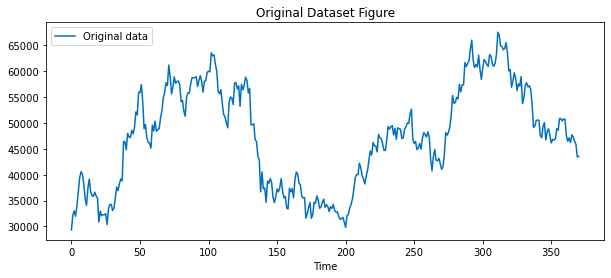

In [48]:
PATH = 'data\\'
FIGURE_PATH = PATH+'figures'
LOG_PATH = PATH+'subset'
DATASET_NAME = 'one_year_complete.csv'
SERIES = pd.Series(df['close'])
PERIODS = period  
series = cl.declare_path(path=PATH,figure_path=FIGURE_PATH,log_path=LOG_PATH,dataset_name=DATASET_NAME,series=SERIES)

In [49]:
#cl.statistical_tests()

##################################
Global Variables
##################################
MODE:EMD
FORM:
DATE_BACK:30
PERIODS:67
EPOCHS:100
PATIENCE:10
EMD decomposition is running.


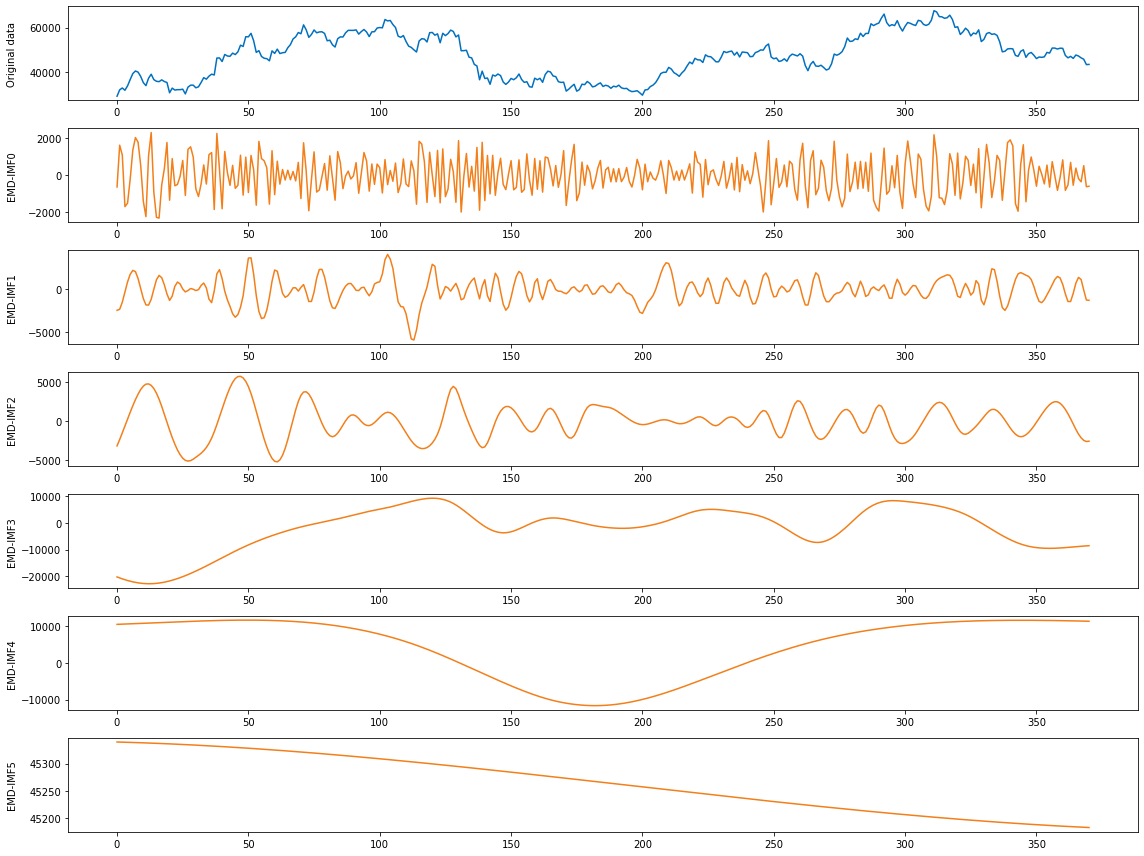

EMD finished, check the dataset:  data\emd_data.csv
Sample entropy of EMD is running.


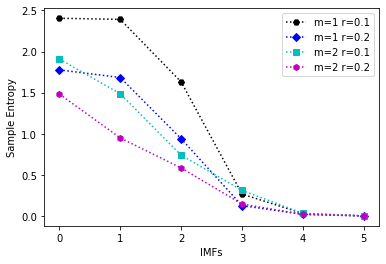

In [50]:
# EMD and its SE
cl.declare_vars(mode='emd', periods=PERIODS)
imfs_emd = cl.emd_decom()
cl.sample_entropy() # SE

The Integrating Form: 222


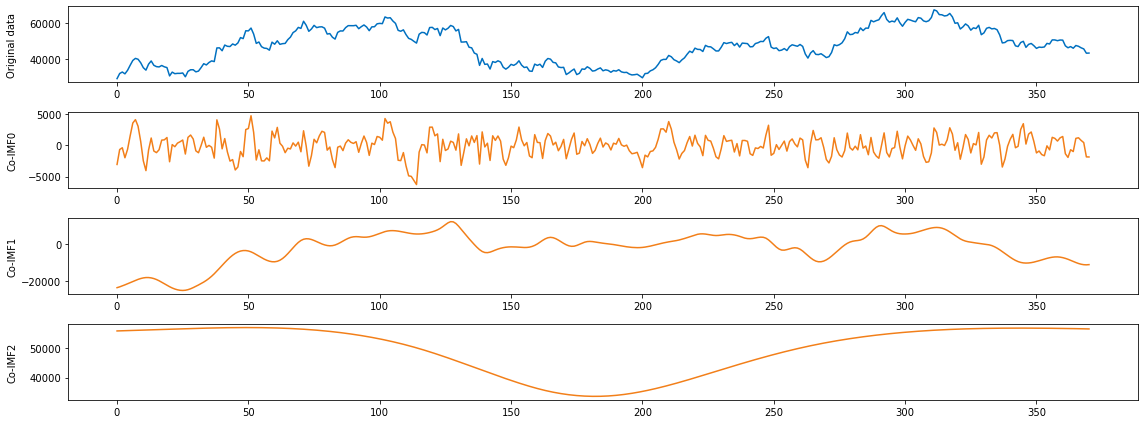

Integration finished, check the dataset:  data\emd_se222_data.csv


In [51]:
form = [[0,1],[2,3],[4,5]] # form 233
cl.integrate(inte_form=form) 

##################################
Global Variables
##################################
MODE:EMD_SE
FORM:222
DATE_BACK:30
PERIODS:67
EPOCHS:1000
PATIENCE:100
This is Respective LSTM Forecasting running...
Part of Inputting dataset:
         co-imf0       co-imf1       co-imf2
0   -3073.631228 -23445.520169  55850.841397
1    -689.404082 -23010.082208  55877.816290
2    -402.648844 -22502.098462  55904.797306
3   -2002.139445 -21940.969589  55931.819034
4    -663.289815 -21346.096246  55958.916061
..           ...           ...           ...
366  1196.468773 -10519.714703  56609.425930
367   771.227108 -10916.707876  56591.580768
368   422.960403 -11163.814431  56572.864028
369 -1863.270017 -11238.854644  56553.254661
370 -1876.935269 -11127.796350  56532.731619

[371 rows x 3 columns]
EMD_SE--IMF0

Input Shape: (30,1)

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_16 (LSTM) 

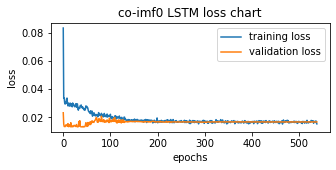

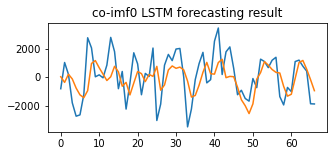

EMD_SE--IMF1

Input Shape: (30,1)

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_19 (LSTM)               (None, 30, 128)           66560     
_________________________________________________________________
dropout_12 (Dropout)         (None, 30, 128)           0         
_________________________________________________________________
lstm_20 (LSTM)               (None, 30, 64)            49408     
_________________________________________________________________
dropout_13 (Dropout)         (None, 30, 64)            0         
_________________________________________________________________
lstm_21 (LSTM)               (None, 32)                12416     
_________________________________________________________________
dropout_14 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_11 (Dense)  

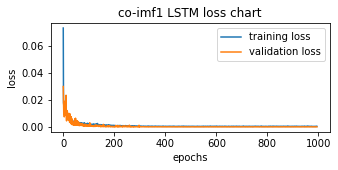

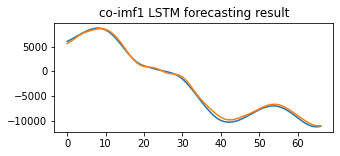

EMD_SE--IMF2

Input Shape: (30,1)

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_22 (LSTM)               (None, 30, 128)           66560     
_________________________________________________________________
dropout_15 (Dropout)         (None, 30, 128)           0         
_________________________________________________________________
lstm_23 (LSTM)               (None, 30, 64)            49408     
_________________________________________________________________
dropout_16 (Dropout)         (None, 30, 64)            0         
_________________________________________________________________
lstm_24 (LSTM)               (None, 32)                12416     
_________________________________________________________________
dropout_17 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_12 (Dense)  

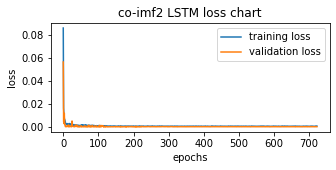

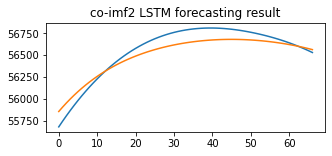

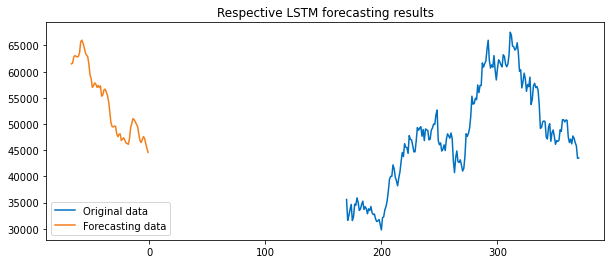

##################################
Model Evaluation with scale of input df
##################################
R2: 0.9571397990611701
RMSE: 1398.3120009016643
MAE: 1152.9763829291037
MAPE: 2.141617872520508
Running time: 672.255s
Respective LSTM Forecasting finished, check the logs data\subset\respective_emd_se222_log.csv


,co-imf0,co-imf1,co-imf2
0,32.687801,5601.991211,55859.906250
1,-365.557922,6063.378906,55910.074219
2,209.052170,6630.906738,55957.730469
3,-123.255363,7189.107910,56002.984375
4,-764.283630,7641.857422,56045.921875
...,...,...,...
62,1026.380615,-10036.676758,56606.511719
63,1174.173950,-10500.295898,56597.269531
64,557.966675,-10850.545898,56587.421875
65,-173.146576,-11035.595703,56576.937500


In [52]:
cl.declare_vars(mode='emd_se',form='222',epochs=1000, periods=PERIODS) 
cl.Respective_LSTM()

In [53]:
# Normalized Integration
df_res = pd.read_csv(PATH+'subset\\respective_emd_se222_pred.csv',header=0,index_col=0)
res_pred = df_res.T.sum().values
rate = series.max()-series.min()
series_nor = (series-series.min())/float(rate)
res_pred = (res_pred-series.min())/float(rate)
df_evl = cl.evl(series_nor[-PERIODS:].values,res_pred,scale='btc prices')

##################################
Model Evaluation with scale of btc prices
##################################
R2: 0.9571397978550114
RMSE: 0.03661064290430678
MAE: 0.030187259465035216
MAPE: 4.909787720375157


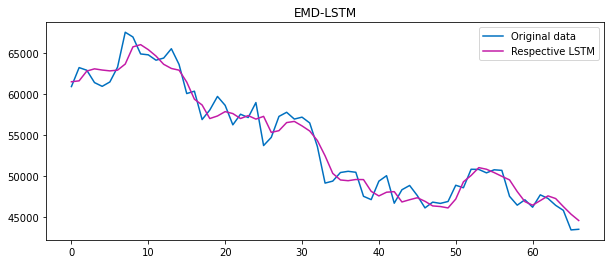

In [57]:
# Plot 

df_res = pd.read_csv('data/subset/respective_emd_se222_pred.csv',header=0,index_col=0)
res_pred = df_res.T.sum().values

# Plot original data by series
#PERIODS = periods # 
length = range(PERIODS)
fig = plt.figure(figsize=(10,4))
plt.plot(length, series[-PERIODS:], label= 'Original data', color='#0070C0') #F27F19 orange #0070C0 blue
plt.plot(length, res_pred, label= 'Respective LSTM', color='#C31BA7') #C31BA7 pink
plt.xlabel('')
plt.legend()
plt.title('EMD-LSTM')
plt.savefig('EMD-LSTM.svg', bbox_inches='tight')
plt.show()

In [58]:
res_pred

array([61494.5848  , 61607.89508 , 62797.68887 , 63068.83664 ,
       62923.4938  , 62820.3665  , 62909.8809  , 63652.4982  ,
       65745.04157 , 66016.6729  , 65404.6138  , 64627.85473 ,
       63623.19258 , 63115.769602, 62906.36855 , 61459.56528 ,
       59371.31045 , 58665.61242 , 57013.8816  , 57326.72072 ,
       57858.67098 , 57620.28244 , 57017.093   , 57375.1499  ,
       56945.889274, 57281.995434, 55324.22457 , 55540.23401 ,
       56523.55492 , 56666.76332 , 56120.43085 , 55498.8966  ,
       54332.67025 , 52476.76173 , 50333.2435  , 49534.3989  ,
       49444.56706 , 49591.02693 , 49580.5547  , 48147.41597 ,
       47589.0917  , 48042.694   , 48112.6198  , 46856.16918 ,
       47127.382573, 47369.424272, 46936.2046  , 46374.0101  ,
       46299.2198  , 46128.0126  , 47205.9497  , 49310.90583 ,
       50081.74332 , 51038.9726  , 50840.25066 , 50430.89555 ,
       49978.29226 , 49544.08035 , 48122.3187  , 46893.0151  ,
       46464.2376  , 47021.1038  , 47596.2136  , 47271.

In [59]:
preds = Average()([res_pred, test_predict])

In [60]:
preds

<tf.Tensor: shape=(67,), dtype=float32, numpy=
array([61029.82 , 60592.22 , 61101.605, 62646.395, 61752.4  , 60937.027,
       61064.758, 62255.234, 63918.695, 65863.125, 66239.195, 64159.938,
       63102.406, 62895.586, 63134.89 , 62761.51 , 61727.375, 59617.188,
       58154.883, 57349.367, 57569.336, 58518.18 , 57959.1  , 56913.164,
       56787.543, 56386.926, 56638.086, 55264.977, 55141.64 , 56286.28 ,
       57087.215, 56516.69 , 55679.656, 54394.633, 52177.88 , 49537.41 ,
       49252.14 , 49912.36 , 50330.188, 49359.8  , 48330.895, 48125.715,
       48231.45 , 48325.812, 47651.22 , 47673.6  , 47697.36 , 47346.477,
       46709.77 , 46878.883, 47327.426, 48574.984, 49460.582, 50101.83 ,
       51236.367, 51197.92 , 50609.83 , 50561.22 , 49621.043, 48232.914,
       46935.78 , 47260.438, 47032.055, 47166.09 , 46629.594, 45856.816,
       45016.39 ], dtype=float32)>

In [66]:
df_evl = cl.evl(testY,preds)

##################################
Model Evaluation with scale of 0 to 1
##################################
R2: 0.9631933573345676
RMSE: 1282.331209930933
MAE: 990.62325232967
MAPE: 1.818748976193701


##################################
Global Variables
##################################
MODE:CEEMDAN
FORM:
DATE_BACK:30
PERIODS:67
EPOCHS:100
PATIENCE:10
CEEMDAN decomposition is running.


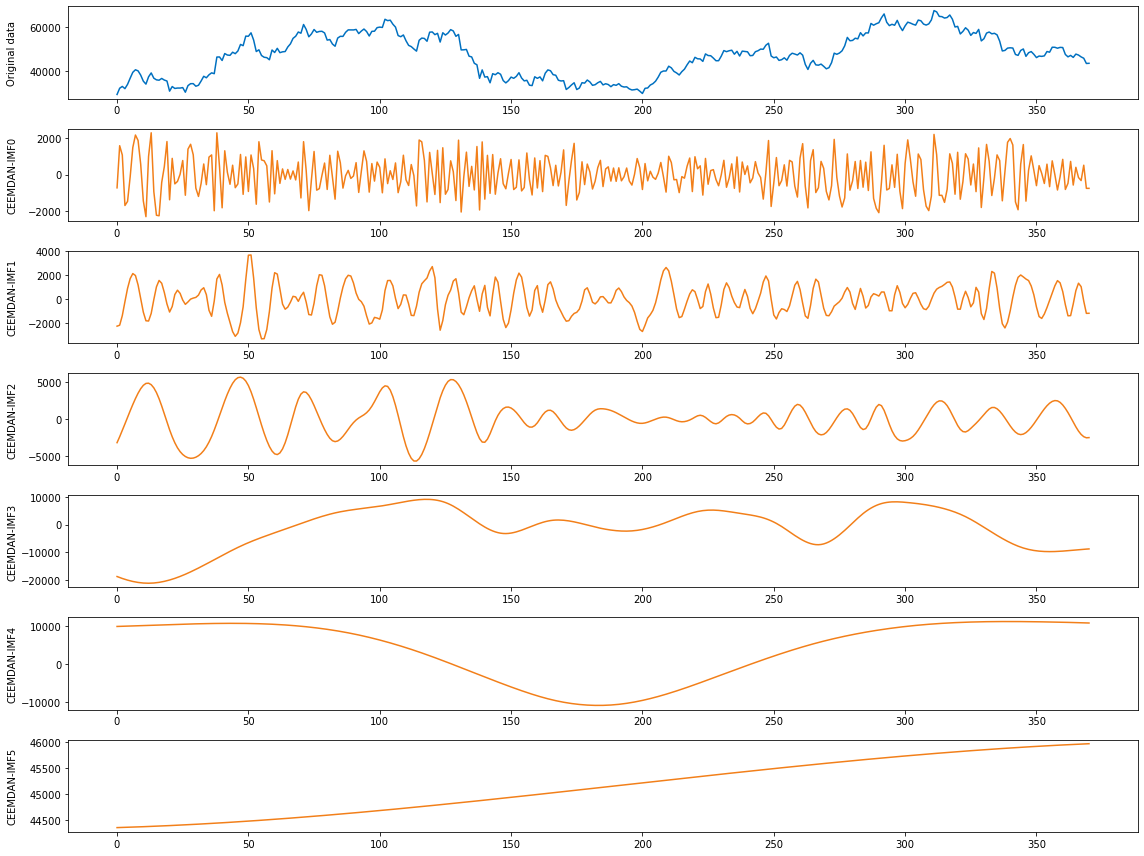

CEEMDAN finished, check the dataset:  data\ceemdan_data.csv
Sample entropy of CEEMDAN is running.


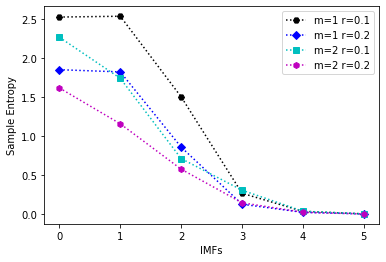

In [67]:
#ceemdan
# CEEMDAN and its SE
cl.declare_vars(mode='ceemdan', periods=PERIODS)
imfs = cl.emd_decom() # CEEMDAN 
cl.sample_entropy() # SE

##################################
Global Variables
##################################
MODE:CEEMDAN
FORM:
DATE_BACK:30
PERIODS:67
EPOCHS:100
PATIENCE:10
The Integrating Form: 222


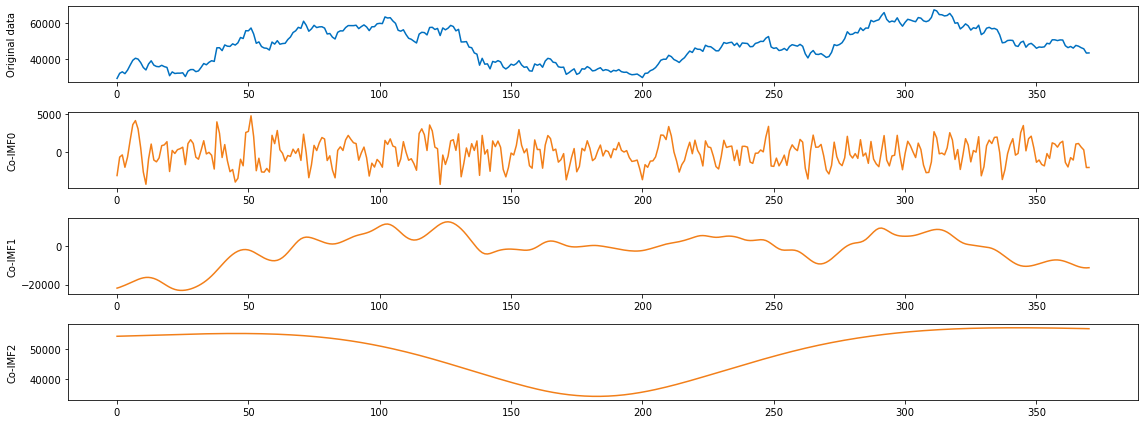

Integration finished, check the dataset:  data\ceemdan_se222_data.csv


In [68]:
# Integrate IMFs of CEEMDAN by SE
cl.declare_vars(mode='ceemdan', periods=PERIODS) # CEEMDAN 
form = [[0,1],[2,3],[4,5]] # form 233
cl.integrate(inte_form=form) 

##################################
Global Variables
##################################
MODE:CEEMDAN_SE
FORM:222
DATE_BACK:30
PERIODS:67
EPOCHS:1000
PATIENCE:100
This is Respective LSTM Forecasting running...
Part of Inputting dataset:
         co-imf0       co-imf1       co-imf2
0   -3002.770241 -21868.184425  54202.644666
1    -615.433986 -21434.163551  54227.927537
2    -328.246490 -20924.843266  54253.139756
3   -1930.560771 -20359.037979  54278.308749
4    -598.369849 -19755.562095  54303.461944
..           ...           ...           ...
366  1145.699444 -10655.074096  56795.554652
367   690.445498 -11021.839758  56777.494260
368   323.190313 -11249.814673  56758.634360
369 -1964.147208 -11323.674340  56738.951548
370 -1956.160363 -11234.262056  56718.422418

[371 rows x 3 columns]
CEEMDAN_SE--IMF0

Input Shape: (30,1)

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_26

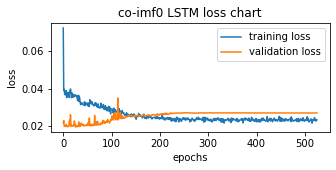

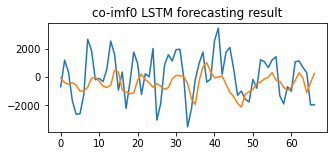

CEEMDAN_SE--IMF1

Input Shape: (30,1)

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_29 (LSTM)               (None, 30, 128)           66560     
_________________________________________________________________
dropout_21 (Dropout)         (None, 30, 128)           0         
_________________________________________________________________
lstm_30 (LSTM)               (None, 30, 64)            49408     
_________________________________________________________________
dropout_22 (Dropout)         (None, 30, 64)            0         
_________________________________________________________________
lstm_31 (LSTM)               (None, 32)                12416     
_________________________________________________________________
dropout_23 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_15 (Dens

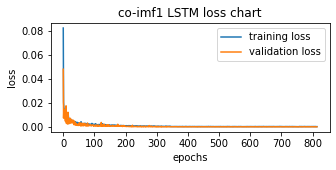

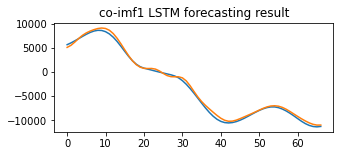

CEEMDAN_SE--IMF2

Input Shape: (30,1)

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_32 (LSTM)               (None, 30, 128)           66560     
_________________________________________________________________
dropout_24 (Dropout)         (None, 30, 128)           0         
_________________________________________________________________
lstm_33 (LSTM)               (None, 30, 64)            49408     
_________________________________________________________________
dropout_25 (Dropout)         (None, 30, 64)            0         
_________________________________________________________________
lstm_34 (LSTM)               (None, 32)                12416     
_________________________________________________________________
dropout_26 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_16 (Dens

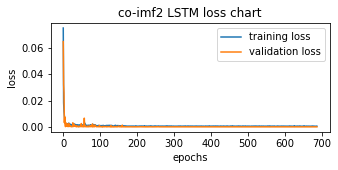

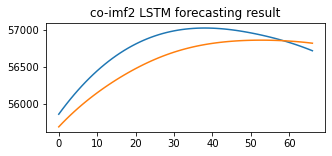

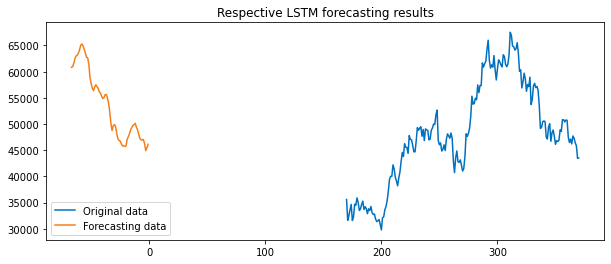

##################################
Model Evaluation with scale of input df
##################################
R2: 0.9441171464581477
RMSE: 1596.6740639252685
MAE: 1313.7335774253727
MAPE: 2.4429865047009915
Running time: 627.470s
Respective LSTM Forecasting finished, check the logs data\subset\respective_ceemdan_se222_log.csv


,co-imf0,co-imf1,co-imf2
0,-28.771858,5159.189453,55694.238281
1,-389.826355,5587.863770,55748.242188
2,-498.669708,6260.855469,55800.167969
3,-393.823761,7007.402832,55850.113281
4,-561.863220,7666.031250,55898.183594
...,...,...,...
62,308.955383,-10104.606445,56840.941406
63,-50.452053,-10500.399414,56836.421875
64,-1101.007324,-10799.430664,56831.402344
65,-390.883667,-10958.283203,56825.878906


In [69]:
cl.declare_vars(mode='ceemdan_se',form='222',epochs=1000, periods=PERIODS) # CEEMDAN 
cl.Respective_LSTM()

In [71]:
# Normalized Integration
df_res_ceemdan = pd.read_csv(PATH+'subset\\respective_ceemdan_se222_pred.csv',header=0,index_col=0)
res_pred_ceemdan = df_res_ceemdan.T.sum().values
rate = series.max()-series.min()
series_nor = (series-series.min())/float(rate)
res_pred = (res_pred_ceemdan-series.min())/float(rate)
df_evl_ceemdan = cl.evl(series_nor[-PERIODS:].values,res_pred_ceemdan,scale='btc prices') 

##################################
Model Evaluation with scale of btc prices
##################################
R2: -93274471085.52277
RMSE: 54008.441529201
MAE: 53614.68644619384
MAPE: 8646701.629642934


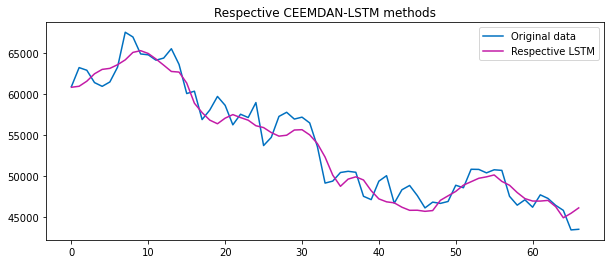

In [72]:
# Plot 

df_res_ceemdan = pd.read_csv('data/subset/respective_ceemdan_se222_pred.csv',header=0,index_col=0)
res_pred_ceemdan = df_res_ceemdan.T.sum().values

# Plot original data by series 
length = range(PERIODS)
fig = plt.figure(figsize=(10,4))
plt.plot(length, series[-PERIODS:], label= 'Original data', color='#0070C0') #F27F19 orange #0070C0 blue
#plt.plot(length, df_sin, label= 'Single LSTM', color='0.7') 
#plt.plot(length, df_ens, label= 'Ensemble LSTM', color='#F27F19') 
plt.plot(length, res_pred_ceemdan, label= 'Respective LSTM', color='#C31BA7') #C31BA7 pink
plt.xlabel('')
plt.legend()
plt.title('Respective CEEMDAN-LSTM methods')
plt.savefig('Respective CEEMDAN-LSTM.svg', bbox_inches='tight')
plt.show()

In [73]:
res_pred_ceemdan

array([60824.657642 , 60946.27965  , 61562.3538   , 62463.69224  ,
       63002.352    , 63126.29715  , 63570.5664   , 64160.4914   ,
       65071.09682  , 65281.711989 , 64935.18277  , 64265.2727   ,
       63519.0283   , 62748.77984  , 62673.8486   , 61334.84217  ,
       58880.58145  , 57739.5829   , 56822.5899   , 56380.0669   ,
       57062.69405  , 57494.91496  , 57134.84432  , 56811.7949   ,
       56140.14975  , 55914.4299   , 55308.4348   , 54871.37643  ,
       54983.6707   , 55617.79949  , 55656.74371  , 55022.7831   ,
       53968.755558 , 52321.8347   , 50122.2059   , 48762.0437   ,
       49638.3098   , 49916.6197   , 49530.50794  , 48223.94594  ,
       47228.93417  , 46871.340028 , 46746.52634  , 46215.76365  ,
       45839.1695   , 45848.8421   , 45714.856    , 45806.969    ,
       47053.4591   , 47600.9599   , 48140.0375   , 48903.7906   ,
       49320.83967  , 49741.53224  , 49913.6911103, 50145.34575  ,
       49360.3082   , 48888.89616  , 48001.2612   , 47266.4490

In [74]:
preds_ceemdan = Average()([res_pred_ceemdan, test_predict])
preds_ceemdan

<tf.Tensor: shape=(67,), dtype=float32, numpy=
array([61641.4  , 61232.254, 61410.688, 63187.688, 62728.883, 62244.46 ,
       62547.664, 63525.918, 64507.844, 66436.61 , 66939.16 , 65126.45 ,
       64360.445, 63891.996, 64131.58 , 63791.297, 62602.65 , 60328.46 ,
       59299.016, 58093.523, 58232.047, 59299.33 , 58817.18 , 57544.254,
       57217.15 , 56566.113, 57417.33 , 55939.53 , 55368.54 , 56529.17 ,
       57553.1  , 57047.895, 56371.906, 55246.094, 53002.508, 50123.477,
       50187.703, 50698.305, 50963.312, 50107.375, 48842.176, 48102.707,
       48102.367, 48625.734, 47654.367, 47548.6  , 47774.375, 47737.32 ,
       47712.453, 48124.258, 48356.14 , 48915.586, 49638.547, 50125.7  ,
       51346.016, 51526.33 , 50833.836, 50837.043, 50266.023, 49129.58 ,
       47854.1  , 47791.14 , 47415.633, 47349.43 , 46611.125, 46526.484,
       46402.348], dtype=float32)>

In [75]:
df_evl_ceemdan = cl.evl(testY,preds_ceemdan)

##################################
Model Evaluation with scale of 0 to 1
##################################
R2: 0.9502323100966383
RMSE: 1491.1140115179473
MAE: 1128.6371044925215
MAPE: 2.1367071797426296


In [ ]:
# Plot comparison chart of the above methods

df_res_ceemdan = pd.read_csv('data/subset/respective_ceemdan_se222_pred.csv',header=0,index_col=0)
res_pred_ceemdan = df_res_ceemdan.T.sum().values

df_res_emd = pd.read_csv('data/subset/respective_emd_se222_pred.csv',header=0,index_col=0)
res_pred_emd = df_res_emd.T.sum().values

length = range(PERIODS)
fig = plt.figure(figsize=(10,4))
plt.plot(length, series[-PERIODS:], label= 'Original data', color='#0070C0') 
plt.plot(length, res_pred_emd, label= 'Respective LSTM', color='#F27F19') 
plt.plot(length, res_pred_ceemdan, label= 'Respective LSTM', color='#C31BA7') 

plt.xlabel('')
plt.legend()
plt.title('Respective CEEMDAN-LSTM vs EMD-LSTM methods')
plt.savefig('Respective CEEMDAN-LSTMvs EMD-LSTM methods.svg', bbox_inches='tight')
plt.show()